In [49]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import telescope 
import aotools



In [50]:
class phaseScreen(object):
    # Using Stategy Pattern to generate the phase screens using and 
    # arbitrary generator function. E.g. Zernike, KL, Kolmogorov, etc.
    def __init__(self, N, strategy, generatorParameters):
        self.N = N
        self.generator = strategy
        self.generatorParameters = generatorParameters
        # Placeholder Attributes
        self.scrn = np.zeros((N,N))
    def setParams(self, **kwargs):
        self.generatorParameters = kwargs
    def generate(self, **kwargs):
        self.scrn = self.generator.generate(self.N, **self.generatorParameters)
        return self.scrn
    def decompose(self, type="zernike",nModes=50):
        if type == "zernike":
            mask = aotools.circle(self.N//2,self.N)
            A = mask*self.scrn
            Z = aotools.zernikeArray(nModes, self.N)
            z = np.array([np.trace(Zj.conj().T @ A ) for Zj in Z]) /self.N**2
            return z
        else:
            # Generate Error
            raise ValueError("Decomposition type not recognised")

# Generator Interface
class generatorStrategy(object):
    def generate(self, N, **kwargs):
        pass

class finitePhaseScreen(generatorStrategy):
    def generate(self, N, **kwargs):
        # unpack the parameters
        r0 = kwargs['r0']
        delta = kwargs['delta']
        L0,l0 = kwargs['L0'], kwargs['l0']
        subHarmonics = kwargs['subHarmonics']
        if subHarmonics == True:
            screen = aotools.turbulence.phasescreen.ft_sh_phase_screen(r0, N, delta, L0, l0)
        else:
            screen = aotools.turbulence.phasescreen.ft_phase_screen(r0, N, delta, L0, l0)
        return screen

In [51]:
wvl = 1550e-9
d   = 0.7
fov_sec = 10
fov = np.deg2rad(fov_sec/3600)

# rclad = 125e-6 # radius of the cladding
# fov = wvl/(6*rclad)

fov_arcsec = np.rad2deg(fov)*3600
print(f"Field of View: {fov_arcsec} arcsec")


N_p = 2**10
N_f = 2**8
simPad = 1
FFTOvresampe = 2
obs = 0.3

Field of View: 10.000000000000002 arcsec


In [52]:
r0 = 0.15
L0,l0 = 10,0.00001
finitePhaseScreenParms = {'r0': r0, 'delta': d/N_p, 'L0': L0, 'l0': l0, 'subHarmonics': True}
phaseScreenGenerator = phaseScreen(N_p, finitePhaseScreen(), finitePhaseScreenParms)


In [53]:
tel = telescope.telescope(wvl, d, fov, N_p, N_f, simPad, FFTOvresampe, obs)
P = phaseScreenGenerator.generate()

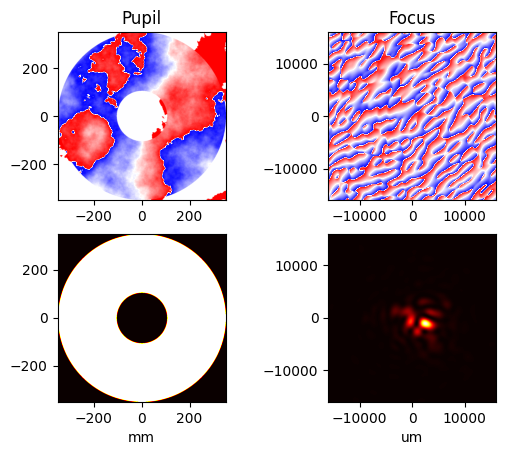

In [54]:
u0 = np.ones_like(P)*np.exp(1j*P)

up = tel.getPupil(u0)
uf = tel.getFocus(u0)

tel.showPupilAndFocus(u0)


In [ ]:

def encircledEnergy(u0,r,ds):
    # Calculate the encircled energy of a field
    # u0 - the field
    # r  - the radius of the encircled energy
    N = u0.shape[0]
    x = np.arange(-N//2,N//2)*ds
    xx,yy = np.meshgrid(x,x)
    rr = np.sqrt(xx**2 + yy**2)
    mask = rr < r
    return np.sum(np.abs(u0[mask])**2)